In [1]:
import pandas as pd
import numpy as np
import random
from quantnote import BacktestEngine, Strategy

In [60]:
result_tree_df = pd.read_parquet('DQN_result_df.parquet').sort_values('sharpe',ascending=False).reset_index(drop=True)
result_tree_df = result_tree_df.drop_duplicates(['sharpe','cagr','vol'])

result_tree_df

,sharpe,cagr,vol,tree
0,1.067617,0.217814,0.204019,"[B:sub, B:mul, currentratio, ebt, netinc]"
1,1.021494,0.203740,0.199453,[sbcomp]
3,1.002581,0.198597,0.198085,[currentratio]
4,0.992744,0.200691,0.202158,[ps1]
6,0.981128,0.204279,0.208208,[ncfdiv]
7,0.968921,0.191690,0.197839,"[B:add, B:sub, sbcomp, divyield, netinccmnusd]"
8,0.953643,0.188314,0.197467,"[B:sub, capex, B:mul, investments, invcapavg]"
9,0.939869,0.180840,0.192410,"[B:add, consolinc, B:sub, pe, retearn]"
10,0.930773,0.177552,0.190757,[pe]
11,0.893190,0.172498,0.193125,[price]


In [14]:
db_path = '/Users/earen/Documents/earendil_git/DB/MainDB.db'

engine = BacktestEngine(db_path)

Loading DB...
DB loaded in 12.45 seconds
[initialize] is executed in 14.61 seconds


In [16]:
indicators = pd.read_csv('/Users/earen/Documents/earendil_git/DB/indicators.csv')
indicators = indicators[indicators.table=='SF1']
indicators = indicators[indicators.unittype != 'date (YYYY-MM-DD)']
indicators = indicators[indicators.unittype != 'text']
print(list(set(indicators.unittype)))
cap_norm = indicators[
    indicators.unittype.apply(lambda x:x in ['USD millions', 'USD', 'currency', 'units'])]
cap_norm = cap_norm[cap_norm.table=='SF1'].indicator.to_list()
cap_norm.remove('marketcap')

unary_list = indicators.indicator.to_list()
binary_list = ['B:add', 'B:sub', 'B:mul', 'B:div']

DQN_result_df = pd.DataFrame({
    'sharpe':[],
    'cagr':[],
    'vol':[],
    'tree':[]
})


len(unary_list)

['units', '%', 'USD', 'currency/share', 'USD/share', 'ratio', 'currency']


105

['B:sub', 'B:mul', 'currentratio', 'ebt', 'netinc']
Backtest period: 2016-06-02 00:00:00 -- 2021-08-31 00:00:00
=== date:2021-08-31 00:00:00 / total_asset:3.135 / time elapsed:19.1 ===
[run_backtest] is executed in 19.35 seconds


C:\Users\earen\Anaconda3\lib\site-packages\quantnote\backtest_engine.py:358: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


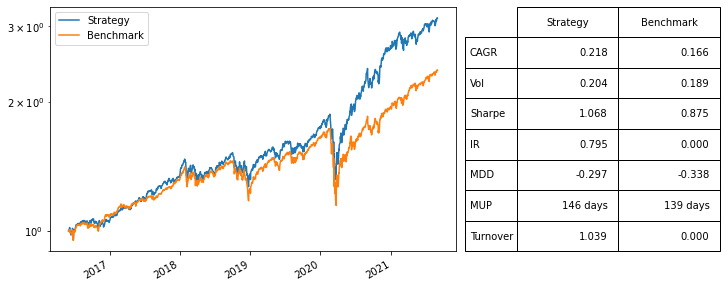

In [44]:
input_list = list(engine.cache['fundamentals']['AAPL'].columns[5:])
unary_list = ['zscore']
binary_list = ['B:add', 'B:sub', 'B:mul', 'B:div']

tree = ['B:sub', 'B:mul', 'currentratio', 'ebt', 'netinc']



mys = myStrategy(tree)
engine.run_backtest(mys, '2016-06-01','2021-08-31',period='Q')
engine.show_report()

C:\Users\earen\Anaconda3\lib\site-packages\quantnote\backtest_engine.py:464: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


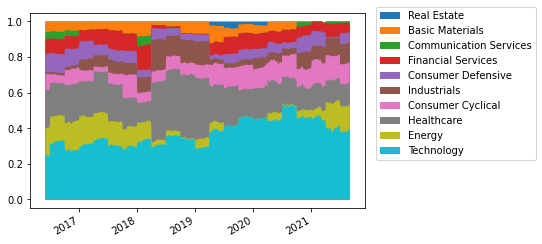

In [45]:
engine.show_sectorflow()

<AxesSubplot:>

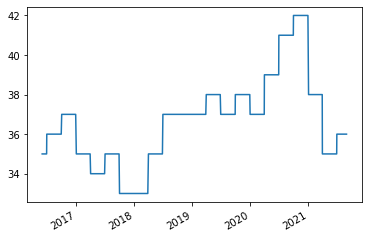

In [46]:
engine.asset_df.apply(lambda x:x>0).sum(axis=1).plot()

<AxesSubplot:>

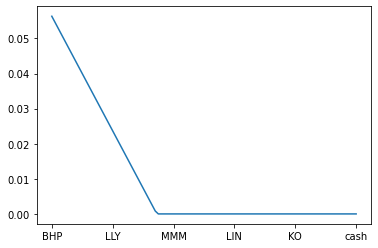

In [47]:
engine.asset_df.iloc[0].sort_values(ascending=False).plot()

In [17]:
class myStrategy(Strategy):
    def __init__(self, tree):
        super().__init__()
        self.tree = tree
        print(tree)
                
    def compute_factor_from_tree(self, universe_list):
        tree = self.tree.copy()
        ops = []
        inputs = []

        while tree:
            x = tree.pop()

            if x[0]=='B': 
                ops.append(x)
            else:
                x = self.compute_factor_series(universe_list, x, type='rank')
                inputs.append(x)

            if len(inputs) >= 2 and len(ops) >= 1:
                x1 = inputs.pop()
                x2 = inputs.pop()
                binary = ops.pop()

                if binary == 'B:add': x = x1 + x2
                elif binary == 'B:sub': x = x1 - x2
                elif binary == 'B:mul': x = x1 * x2
                elif binary == 'B:div': x = x1 / x2
                
                inputs.append(x)
                
        assert len(ops) == 0 and len(inputs) == 1
        x = inputs.pop()
        return x

    
    def compute_target(self, universe_list):
        target_weight = { }
        
        factor_series = self.compute_factor_from_tree(universe_list)
        
        factor_series = self.transform_series(factor_series, 'rank', universe_list)-0.5
        
        for ticker in factor_series.index:
            weight = factor_series[ticker]
            if weight > 0:
                target_weight[ticker] = weight
                
        assert len(target_weight) >= 5
        
        target_weight = self.normalize(target_weight)
        return target_weight

    def custom_factor(self, ticker, ftype):
        if ftype == 'marketcap':
            return self.get_value('metric',ticker,'marketcap')
        else:
            if ftype in cap_norm:
                x = self.get_value('fundamentals',ticker,ftype)/self.get_value('fundamentals',ticker,'marketcap')
            else:
                x = self.get_value('fundamentals',ticker,ftype)
            return x

In [7]:
x = pd.Series([1,2,3,4,56,6])
print(x)
mys=myStrategy([])
mys.transform_series(x,'rank',[12])

0     1
1     2
2     3
3     4
4    56
5     6
dtype: int64
[]


0    0.166667
1    0.333333
2    0.500000
3    0.666667
4    1.000000
5    0.833333
dtype: float64

In [24]:
x.rank()

0    1.0
1    2.0
2    3.0
3    4.0
4    6.0
5    5.0
dtype: float64